In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [17]:
RISK_FREE_RATE = 0.07
MONTHS_IN_YEAR = 12

In [18]:
class CAPM:
    def __init__(self, stock_ticker, bet_csv):
        self.stock_ticker = stock_ticker
        self.bet_csv = bet_csv
        self.data = None
    def load_stock(self):
        print(f"Downloading {self.stock_ticker} from yfinance...")
        try:
            stock = yf.Ticker(self.stock_ticker)
            df = stock.history(period="max")
        except Exception as e:
            print("Error downloading", e)
            return None
        if df.empty:
            raise ValueError(f"No data returned for {self.stock_ticker}")
        if "Adj Close" in df.columns:
            df = df[["Adj Close"]].rename(columns={"Adj Close": "stock"})
        else:
            df = df[["Close"]].rename(columns={"Close": "stock"})
        return df

    # Load Market Data (BET Index) from CSV
    def load_bet_csv(self):
        print(f"Loading BET from: {self.bet_csv}")
        df = pd.read_csv(self.bet_csv, sep=";")
        df.columns = [c.lower().strip() for c in df.columns]
        date_col = [c for c in df.columns if "data" in c or "date" in c][0]
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.set_index(date_col)
        price_col = [c for c in df.columns if "pret" in c or "price" in c][0]
        df = df[[price_col]].rename(columns={price_col: "bet"})
        if df["bet"].dtype == object:
            df["bet"] = (
                df["bet"]
                .astype(str)
                .str.replace(".", "", regex=False)  # remove thousands separator
                .str.replace(",", ".", regex=False)  # decimal comma -> dot
                .str.strip()
            )
        df["bet"] = pd.to_numeric(df["bet"], errors="coerce")
        df = df.dropna()
        df = df[~df.index.duplicated(keep="last")]
        df = df.sort_index()
        return df

    #  Merge and Calculate Returns
    def initialize(self):
        trp = self.load_stock()
        bet = self.load_bet_csv()
        if hasattr(trp.index, 'tz'):
            trp.index = trp.index.tz_localize(None)
        bet.index = pd.to_datetime(bet.index)
        df = pd.concat([trp, bet], axis=1)
        df = df.resample("ME").last()
        df["trp_ret"] = np.log(df["stock"] / df["stock"].shift(1))
        df["bet_ret"] = np.log(df["bet"] / df["bet"].shift(1))
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna()
        if len(df) < 12:
            print("Warning: Dataset is very small (<12 months). Results may be unreliable.")
        self.data = df
        print("\nFinal dataset (TRP + BET monthly returns):")
        print(df)

    # Calculate Beta (Covariance Method)
    def beta_covariance(self):
        cov = np.cov(self.data["trp_ret"], self.data["bet_ret"])
        # cov[0,1] is covariance, cov[1,1] is variance of market
        beta = cov[0, 1] / cov[1, 1]
        print(f"\nBeta (covariance): {beta:.4f}")
        return beta

    # 5. Regression & CAPM Expected Return
    def regression(self):
        x = self.data["bet_ret"]
        y = self.data["trp_ret"]
        beta, alpha = np.polyfit(x, y, 1)
        print(f"Beta (regression): {beta:.4f}")
        print(f"Alpha: {alpha:.4f}")
        annual_bet_return = self.data["bet_ret"].mean() * MONTHS_IN_YEAR
        expected_return = RISK_FREE_RATE + beta * (annual_bet_return - RISK_FREE_RATE)
        print(f"Expected Annual Return (CAPM): {expected_return:.2%}")
        return beta, alpha, expected_return

    def plot(self, beta, alpha):
        plt.figure(figsize=(10, 6))
        plt.scatter(self.data["bet_ret"], self.data["trp_ret"], alpha=0.6, label="Monthly Returns")
        x_line = np.linspace(self.data["bet_ret"].min(), self.data["bet_ret"].max(), 100)
        y_line = beta * x_line + alpha
        plt.plot(x_line, y_line, color="red", label=f"Regression Line (Beta={beta:.2f})")
        plt.title(f"CAPM Regression: {self.stock_ticker} vs BET Index")
        plt.xlabel("Market Returns (BET)")
        plt.ylabel(f"Stock Returns ({self.stock_ticker})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

Loading BET from: Bet.csv

Final dataset (TRP + BET monthly returns):
               stock       bet   trp_ret   bet_ret
2012-09-30  0.010252   4725.11 -0.127802 -0.018403
2012-10-31  0.012038   4925.24  0.160618  0.041482
2012-11-30  0.014593   4790.91  0.192453 -0.027653
2012-12-31  0.015999   5149.56  0.091965  0.072191
2013-01-31  0.017856   5481.29  0.109796  0.062429
...              ...       ...       ...       ...
2025-07-31  0.430983  20189.38  0.207496  0.074733
2025-08-31  0.434981  20557.04  0.009234  0.018047
2025-09-30  0.438000  21337.07  0.006917  0.037242
2025-10-31  0.430500  22516.79 -0.017272  0.053815
2025-11-30  0.428000  22860.42 -0.005824  0.015146

[159 rows x 4 columns]

Beta (covariance): 0.7169
Beta (regression): 0.7169
Alpha: 0.0156
Expected Annual Return (CAPM): 10.41%


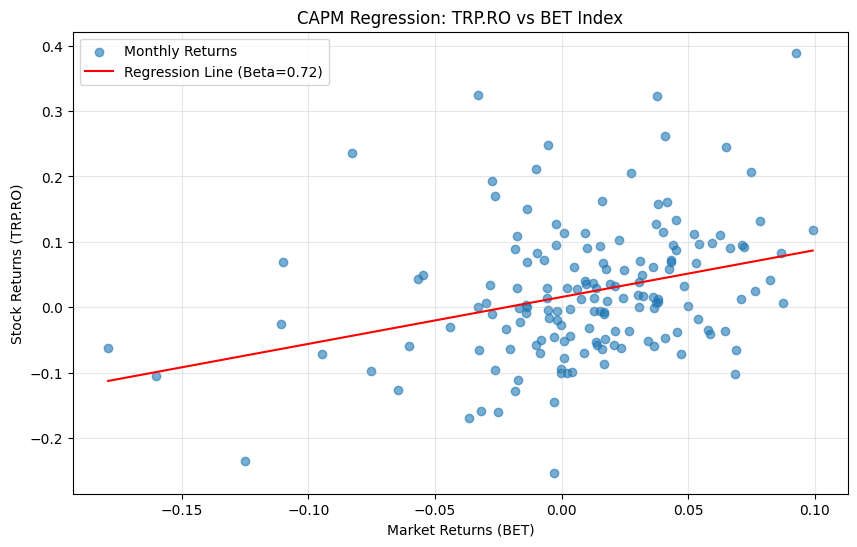

In [19]:
if __name__ == "__main__":
    capm = CAPM("TRP.RO", "Bet.csv")
    try:
        capm.initialize()
        beta_cov = capm.beta_covariance()
        beta, alpha, exp_ret = capm.regression()
        capm.plot(beta, alpha)
    except Exception as e:
        print(f"\nAn error occurred: {e}")